## Import libraries

In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

## Import Data

In [2]:
# import kagglehub
#
# # Download latest version
# path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
#
# print("Path to dataset files:", path)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df_full = pd.read_csv(url)

df_full.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
df = df_full[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].copy()
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Normalize the Features

going to write about what normalization is here

In [4]:
X = StandardScaler().fit_transform(df)

## PCA Reduced data BEFORE Clustering

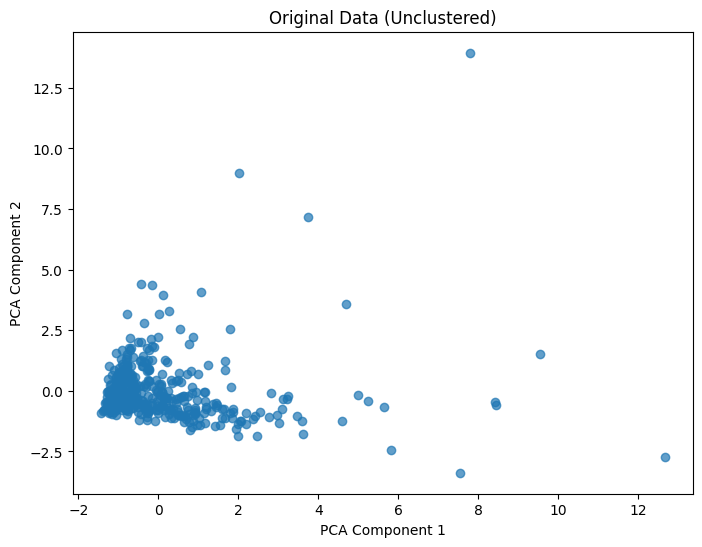

In [5]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.7)
plt.title("Original Data (Unclustered)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## PCA Visualization segmented by Channel

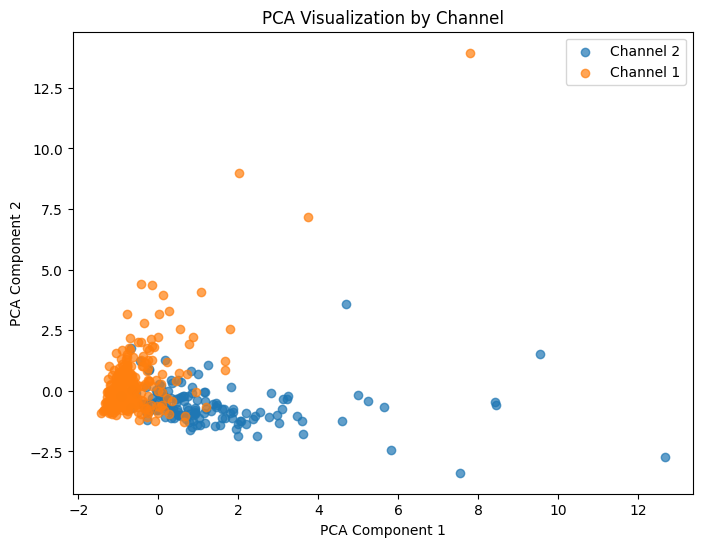

In [6]:
# PCA coords already computed: X_2d
df_full["PC1"] = X_2d[:,0]
df_full["PC2"] = X_2d[:,1]

plt.figure(figsize=(8,6))
for ch in df_full["Channel"].unique():
    subset = df_full[df_full["Channel"] == ch]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Channel {ch}", alpha=0.7)

plt.title("PCA Visualization by Channel")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

## PCA Visualization segmented by Region

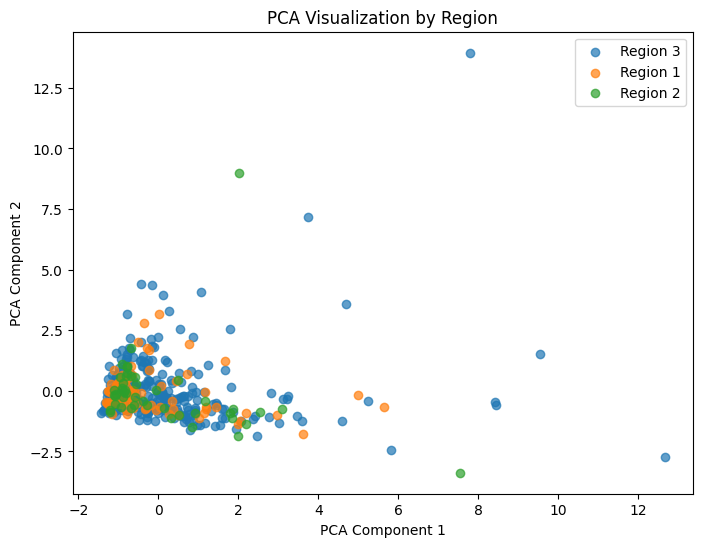

In [7]:
plt.figure(figsize=(8,6))
for reg in df_full["Region"].unique():
    subset = df_full[df_full["Region"] == reg]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Region {reg}", alpha=0.7)

plt.title("PCA Visualization by Region")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

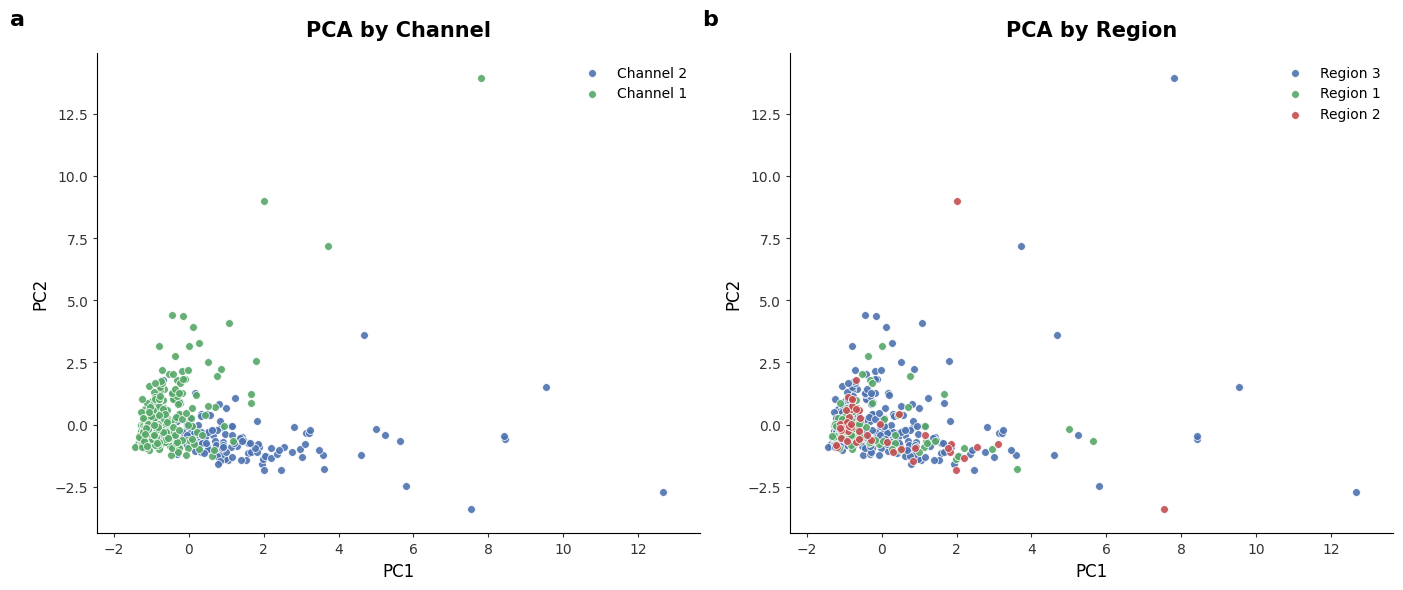

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Custom Nature/Science palette (works for any number of categories)
def ns_palette(n):
    base = [
        "#4C72B0", "#55A868", "#C44E52", "#8172B2",
        "#CCB974", "#64B5CD", "#937860", "#8C8C8C"
    ]
    return base[:n]

# Prepare data
channels = df_full["Channel"].unique()
regions = df_full["Region"].unique()

palette_ch = ns_palette(len(channels))
palette_rg = ns_palette(len(regions))

# Shared axis limits for both plots
xlim = (df_full["PC1"].min() - 1, df_full["PC1"].max() + 1)
ylim = (df_full["PC2"].min() - 1, df_full["PC2"].max() + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
(ax1, ax2) = axes

# =======================
# Panel A — Channel
# =======================
for ch, color in zip(channels, palette_ch):
    subset = df_full[df_full["Channel"] == ch]
    ax1.scatter(
        subset["PC1"],
        subset["PC2"],
        s=32,
        color=color,
        edgecolor="white",
        linewidth=0.6,
        alpha=0.9,
        label=f"Channel {ch}"
    )

ax1.set_title("PCA by Channel", fontsize=15, weight="bold", pad=12)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

# Minimalist Nature/Science styling
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)
ax1.spines["bottom"].set_linewidth(0.8)
ax1.spines["left"].set_linewidth(0.8)
ax1.tick_params(colors="#333333", labelsize=10, length=3, width=0.8)

ax1.set_xlabel("PC1", fontsize=12)
ax1.set_ylabel("PC2", fontsize=12)
ax1.legend(frameon=False, fontsize=10)

# Panel label
ax1.text(-0.12, 1.05, "a", transform=ax1.transAxes,
         fontsize=16, weight="bold", ha="right", va="bottom")

# =======================
# Panel B — Region
# =======================
for reg, color in zip(regions, palette_rg):
    subset = df_full[df_full["Region"] == reg]
    ax2.scatter(
        subset["PC1"],
        subset["PC2"],
        s=32,
        color=color,
        edgecolor="white",
        linewidth=0.6,
        alpha=0.9,
        label=f"Region {reg}"
    )

ax2.set_title("PCA by Region", fontsize=15, weight="bold", pad=12)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

# Styling
for spine in ["top", "right"]:
    ax2.spines[spine].set_visible(False)
ax2.spines["bottom"].set_linewidth(0.8)
ax2.spines["left"].set_linewidth(0.8)
ax2.tick_params(colors="#333333", labelsize=10, length=3, width=0.8)

ax2.set_xlabel("PC1", fontsize=12)
ax2.set_ylabel("PC2", fontsize=12)
ax2.legend(frameon=False, fontsize=10)

# Panel label
ax2.text(-0.12, 1.05, "b", transform=ax2.transAxes,
         fontsize=16, weight="bold", ha="right", va="bottom")

plt.tight_layout()
plt.show()

## Choosing Linking method

In [8]:
# Linkage matrix using Ward's method
Z = linkage(X, method='ward')

# Choose number of clusters (e.g., 3)
labels = fcluster(Z, t=3, criterion='maxclust')

## PCA Reduced data AFTER Clustering

### Ward

In [27]:
# methods = ["single", "complete", "average", "ward"]
#
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# axes = axes.ravel()   # flatten grid for easy indexing
#
# for ax, m in zip(axes, methods):
#     Z = linkage(X, method=m)
#     labels = fcluster(Z, t=3, criterion="maxclust")
#
#     ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab10", alpha=0.7, s=25)
#     ax.set_title(f"{m.capitalize()} Linkage")
#     ax.set_xlabel("PCA Component 1")
#     ax.set_ylabel("PCA Component 2")
#
# plt.tight_layout()
# plt.show()

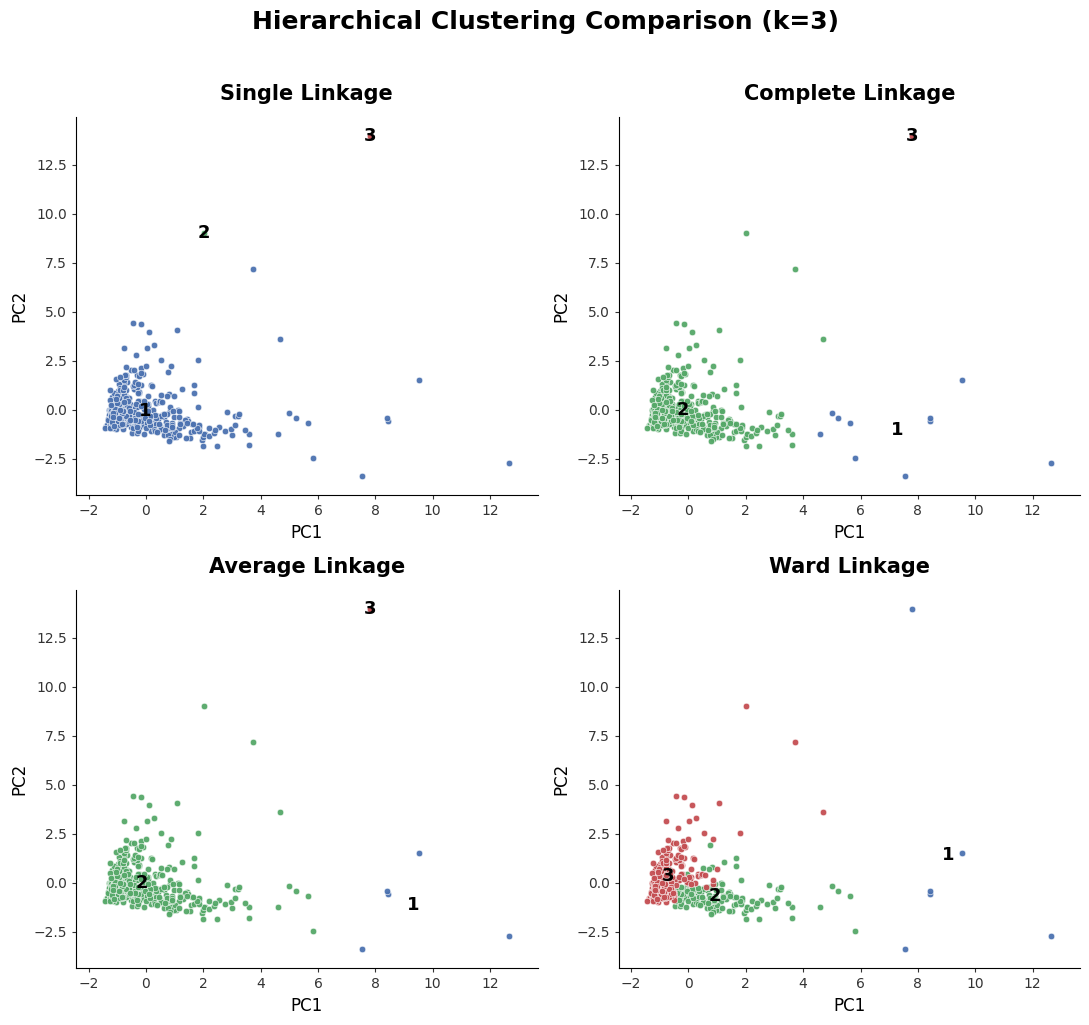

In [26]:
palette = ["#4C72B0", "#55A868", "#C44E52"]

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Nature/Science-style palette (3 clusters)
palette = ["#4C72B0", "#55A868", "#C44E52"]

methods = ["single", "complete", "average", "ward"]

fig, axes = plt.subplots(2, 2, figsize=(11, 10))
axes = axes.ravel()

# Shared axis limits
xlim = (X_2d[:,0].min() - 1, X_2d[:,0].max() + 1)
ylim = (X_2d[:,1].min() - 1, X_2d[:,1].max() + 1)

for ax, method in zip(axes, methods):

    # Compute clustering
    Z = linkage(X, method=method)
    labels = fcluster(Z, t=3, criterion="maxclust")

    # Scatter plot
    for k in np.unique(labels):
        pts = X_2d[labels == k]
        ax.scatter(
            pts[:,0], pts[:,1],
            s=22,
            color=palette[k-1],
            edgecolor="white",
            linewidth=0.4,
            alpha=0.95
        )

    # Cluster label text (center of mass)
    for k in np.unique(labels):
        cx, cy = X_2d[labels == k].mean(axis=0)
        ax.text(cx, cy, str(k),
                fontsize=13, weight="bold",
                ha="center", va="center",
                color="black")

    # Minimalist Nature/Science styling
    ax.set_title(f"{method.capitalize()} Linkage",
                 fontsize=15, weight="bold",
                 pad=12)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Remove top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Thin spines
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)

    # Tick params
    ax.tick_params(
        colors="#333333",
        labelsize=10,
        length=3,
        width=0.8
    )

    ax.set_xlabel("PC1", fontsize=12)
    ax.set_ylabel("PC2", fontsize=12)

fig.suptitle("Hierarchical Clustering Comparison (k=3)",
             fontsize=18, weight="bold", y=1.02)

plt.tight_layout()
plt.show()



## How HC does the clustering (dendrogram)

In [15]:
#dendrogram(Z)

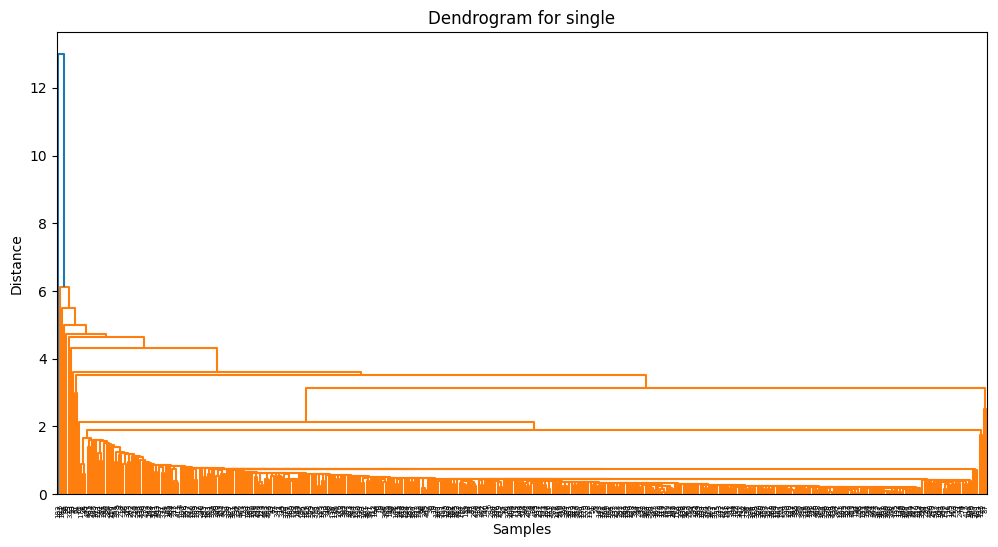

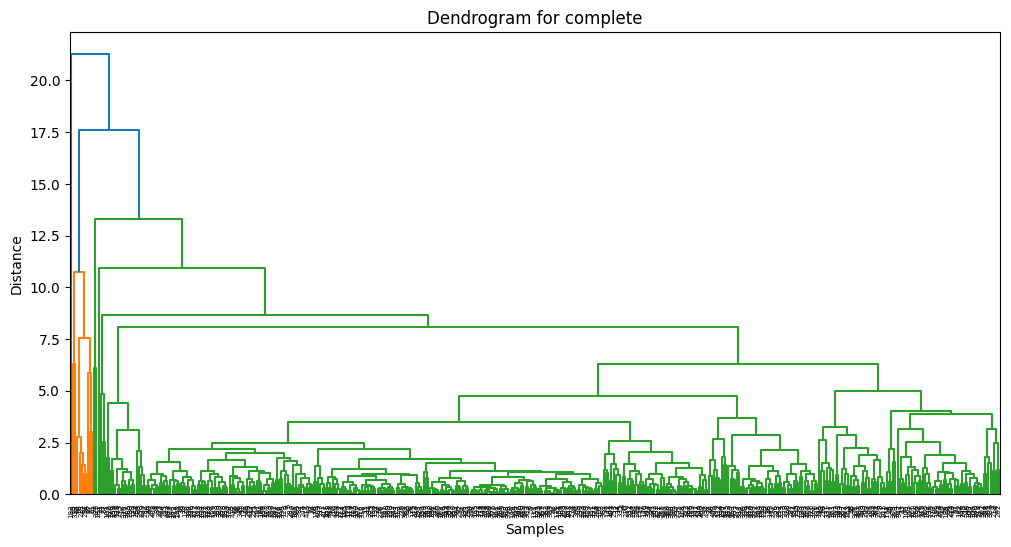

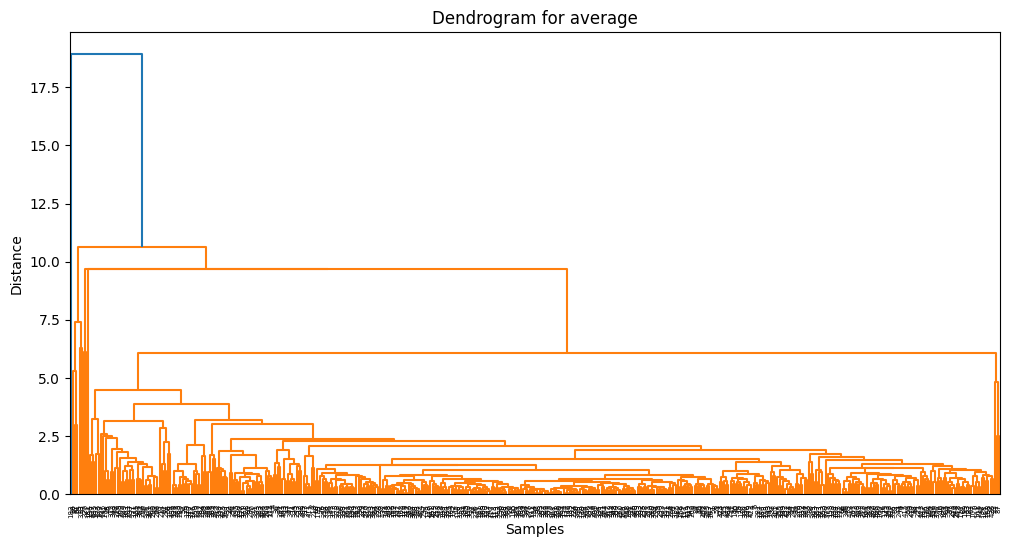

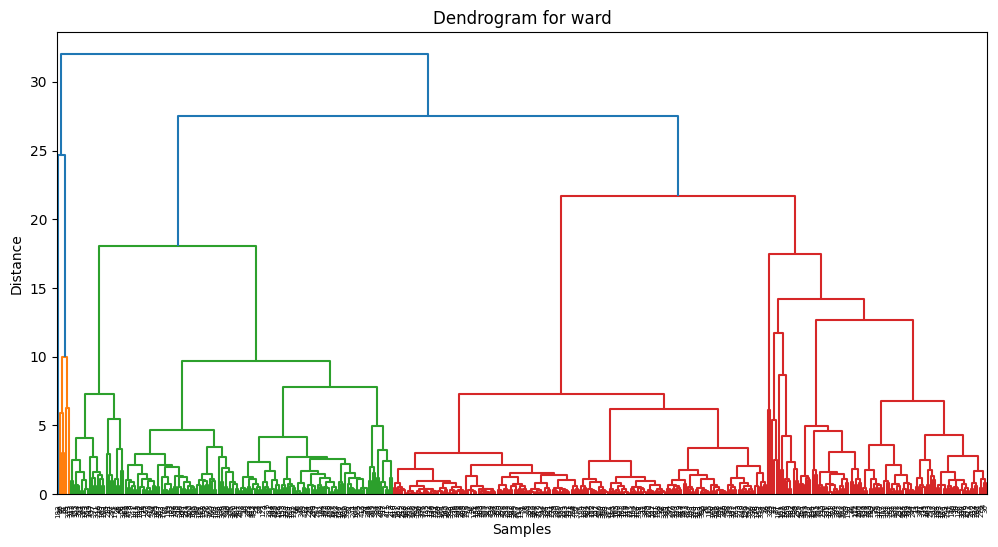

In [17]:
for m in methods:
    # compute linkage for this method
    Z = linkage(X, method=m)

    plt.figure(figsize=(12,6))
    dendrogram(Z)
    plt.title(f"Dendrogram for {m}")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

In [32]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, fcluster

methods = ["single", "complete", "average", "ward"]

rows = []

for m in methods:
    Z = linkage(X, method=m)
    labels = fcluster(Z, t=3, criterion="maxclust")

    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)

    rows.append([m, sil, dbi, ch])

metrics_df = pd.DataFrame(rows, columns=["Linkage", "Silhouette", "DBI", "CH"])
metrics_df

,Linkage,Silhouette,DBI,CH
0,single,0.796648,0.123460,51.430710
1,complete,0.711531,0.513232,116.951977
2,average,0.767580,0.452258,97.882691
3,ward,0.264609,1.284521,111.151039


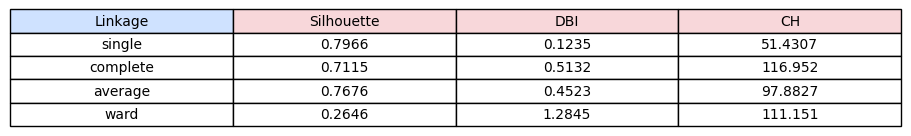

In [33]:
import matplotlib.pyplot as plt

def render_metrics_table(df):
    fig, ax = plt.subplots(figsize=(10, 1.5))
    ax.axis('off')

    # Colors
    col_colors = ["#cfe2ff"] + ["#f8d7da"]*3  # blue for linkage, red for metrics

    table = ax.table(
        cellText=df.round(4).values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colColours=col_colors
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.15, 1.4)

    plt.show()

render_metrics_table(metrics_df)

In [19]:
Z = linkage(X, method="ward")
labels = fcluster(Z, t=3, criterion="maxclust")


df_with_labels = df.copy()
df_with_labels["Cluster"] = labels

In [20]:
df_with_labels.groupby("Cluster").mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
1,27477.000000,43542.166667,54588.500000,8285.666667,25018.333333,10247.833333
2,5794.241830,9419.888889,13761.738562,1461.764706,5913.379085,1577.607843
3,15048.932384,3017.298932,3791.761566,3837.316726,758.007117,1309.900356


## Comparing with a ground truth

In [34]:
df_full_with_clusters = df_full.copy()
df_full_with_clusters["Cluster"] = labels

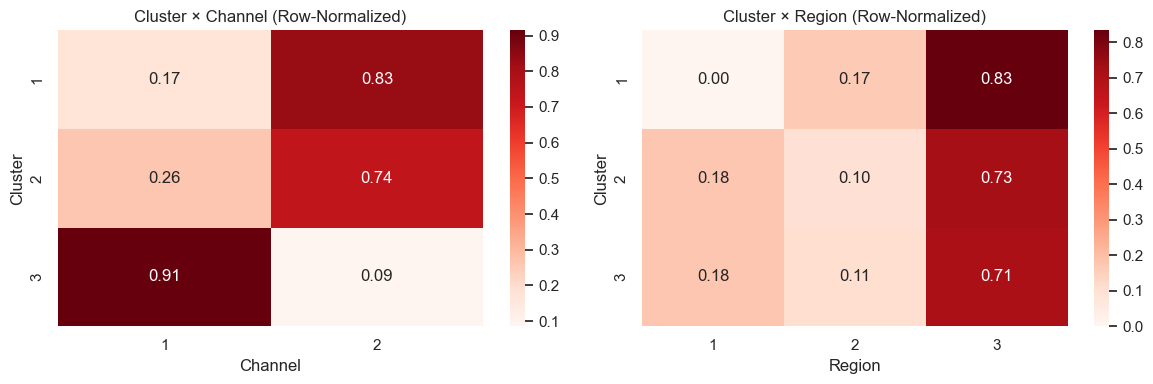

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Channel crosstab
ct_channel = pd.crosstab(
    df_full_with_clusters["Cluster"],
    df_full_with_clusters["Channel"],
    normalize="index"
)

# Region crosstab
ct_region = pd.crosstab(
    df_full_with_clusters["Cluster"],
    df_full_with_clusters["Region"],
    normalize="index"
)

# Side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Left: Channel ---
sns.heatmap(ct_channel, annot=True, cmap="Reds", fmt=".2f", ax=axes[0])
axes[0].set_title("Cluster × Channel (Row-Normalized)")
axes[0].set_xlabel("Channel")
axes[0].set_ylabel("Cluster")

# --- Right: Region ---
sns.heatmap(ct_region, annot=True, cmap="Reds", fmt=".2f", ax=axes[1])
axes[1].set_title("Cluster × Region (Row-Normalized)")
axes[1].set_xlabel("Region")
axes[1].set_ylabel("Cluster")

plt.tight_layout()
plt.show()

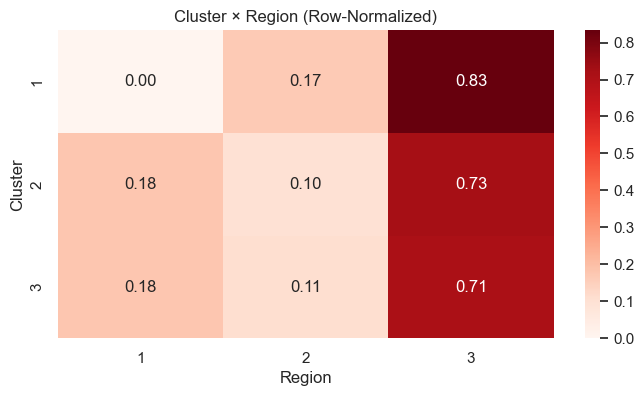

In [77]:
ct_region = pd.crosstab(df_full_with_clusters["Cluster"], df_full_with_clusters["Region"], normalize="index")

plt.figure(figsize=(8,4))
sns.heatmap(ct_region, annot=True, cmap="Reds", fmt=".2f")
plt.title("Cluster × Region (Row-Normalized)")
plt.xlabel("Region")
plt.ylabel("Cluster")
plt.show()

## Evaluation of Clusters vs. Ground Truth Labels

So we see that we have pretty decent scores, better than no association for the Channel label compared to our Clusters. However, our clusters do not capture anything about Region at all basically

In [39]:
ari_channel = adjusted_rand_score(df_full_with_clusters["Channel"], df_full_with_clusters["Cluster"])
ari_region  = adjusted_rand_score(df_full_with_clusters["Region"],  df_full_with_clusters["Cluster"])

nmi_channel = normalized_mutual_info_score(df_full_with_clusters["Channel"], df_full_with_clusters["Cluster"])
nmi_region  = normalized_mutual_info_score(df_full_with_clusters["Region"],  df_full_with_clusters["Cluster"])

print("ARI vs Channel:", ari_channel)
print("ARI vs Region :", ari_region)
print("NMI vs Channel:", nmi_channel)
print("NMI vs Region :", nmi_region)

ARI vs Channel: 0.4856417426338801
ARI vs Region : -0.009461378685953191
NMI vs Channel: 0.3528713991994401
NMI vs Region : 0.003902995299925265
